# Análisis Expandido de CLAP Scores: Discriminación por Categoría de Taste

Este análisis evalúa el impacto del reprompting en la calidad de alineación texto-audio mediante CLAP scores por categorías de sabor (taste). 

Se quiere identificar si el beneficio del reprompt varía según la categoría de sabor del food item asociado.

**Data**:
- 49 pares de evaluaciones (filtrado 'No Label')
- Tres condiciones: Sin Reprompt, Cross-Evaluation, Con Reprompt
- Cuatro categorías de taste: **salty** (20), **sweet** (18), **bitter** (9), **sour** (2)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

from config import PROJECT_ROOT, load_config, setup_project_paths

setup_project_paths()
config = load_config()

CLAP_SCORES_PATH = PROJECT_ROOT / config.data.data_clap_path

df_prompt = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs.csv'))
df_reprompt = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_reprompt_outputs.csv'))
df_cross = pd.read_csv(str(CLAP_SCORES_PATH / 'clap_score_results_prompt_outputs_cross_evaluation.csv'))
df_taste = pd.read_csv(str(CLAP_SCORES_PATH / 'prompts_food_taste.csv'))

# Preparar datos combinados
comparison_df = df_prompt[['id_prompt', 'text', 'clap_score']].merge(
    df_cross[['id_prompt', 'clap_score']], 
    on='id_prompt', 
    suffixes=('_sin_reprompt', '_cross_eval')
).merge(
    df_reprompt[['id_prompt', 'text', 'clap_score']], 
    on='id_prompt',
    suffixes=('', '_reprompt_text')
).rename(columns={
    'clap_score': 'clap_score_con_reprompt',
    'text_reprompt_text': 'text_reprompt'
})

comparison_df['diferencia_reprompt'] = (
    comparison_df['clap_score_con_reprompt'] - comparison_df['clap_score_sin_reprompt']
)


comparison_df = comparison_df.merge(df_taste[['id_prompt', 'food', 'taste']], on='id_prompt')
comparison_df = comparison_df[comparison_df['taste'] != 'No Label'].copy()

## 1. Estadísticas descriptivas generales

Resumen CLAP scores:

In [2]:
summary_stats = pd.DataFrame({
    'Sin Reprompt': comparison_df['clap_score_sin_reprompt'].describe(),
    'Cross Eval': comparison_df['clap_score_cross_eval'].describe(),
    'Con Reprompt': comparison_df['clap_score_con_reprompt'].describe()
}).round(4)

summary_stats

,Sin Reprompt,Cross Eval,Con Reprompt
count,49.0000,49.0000,49.0000
mean,0.1169,0.1217,0.1765
std,0.1125,0.1008,0.2028
min,-0.1171,-0.1457,-0.2576
25%,0.0625,0.0573,0.0357
50%,0.1189,0.1210,0.1710
75%,0.1914,0.1910,0.3366
max,0.3984,0.3405,0.6152


## 2. Análisis por categoría de taste

Distribución de muestras por sabor:

In [3]:
comparison_df['taste'].value_counts()

taste
salty     20
sweet     18
bitter     9
sour       2
Name: count, dtype: int64

### Estadísticas comparativas por taste

In [4]:
summary_taste = []
for taste in ['salty', 'sweet', 'bitter', 'sour']:
    subset = comparison_df[comparison_df['taste'] == taste]
    t_stat, p_val = stats.ttest_rel(subset['clap_score_sin_reprompt'],
                                      subset['clap_score_con_reprompt'])

    summary_taste.append({
        'Taste': taste,
        'N': len(subset),
        'Sin_Reprompt_μ': subset['clap_score_sin_reprompt'].mean(),
        'Con_Reprompt_μ': subset['clap_score_con_reprompt'].mean(),
        'Diferencia_μ': subset['diferencia_reprompt'].mean(),
        'Cambio_%': (subset['diferencia_reprompt'].mean() / 
                     subset['clap_score_sin_reprompt'].mean()) * 100,
        't_stat': t_stat,
        'p_value': p_val,
        'Mejoraron': (subset['diferencia_reprompt'] > 0).sum() / len(subset) * 100
    })

summary_taste_df = pd.DataFrame(summary_taste).round(4)
summary_taste_df

,Taste,N,Sin_Reprompt_μ,Con_Reprompt_μ,Diferencia_μ,Cambio_%,t_stat,p_value,Mejoraron
0,salty,20,0.0781,0.1828,0.1046,133.8995,-2.8525,0.0102,75.0000
1,sweet,18,0.1409,0.2738,0.1329,94.3043,-2.0517,0.0559,66.6667
2,bitter,9,0.1512,0.0320,-0.1192,-78.8363,2.1668,0.0621,22.2222
3,sour,2,0.1344,-0.1109,-0.2453,-182.5154,1.1298,0.4612,0.0000


**Hallazgos Clave por Categoría**:

- **Salty** (n=20): Mejora significativa con reprompt (p=0.010 < 0.05), 75% mejoraron, cambio promedio +134%
- **Sweet** (n=18): Tendencia a mejora (p=0.056), 67% mejoraron, cambio promedio +94%
- **Bitter** (n=9): Tendencia a empeoramiento (p=0.062), 78% empeoraron, cambio promedio -79%
- **Sour** (n=2): Ambos empeoraron (-183%)

## 3. Visualización: Distribuciones por Taste

/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_84037/2913360674.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_84037/2913360674.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
/var/folders/p3/7n0xc16x2cz3psh_2bhr4m8w0000gn/T/ipykernel_84037/2913360674.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
/var/folders/p3/7n0xc16x2

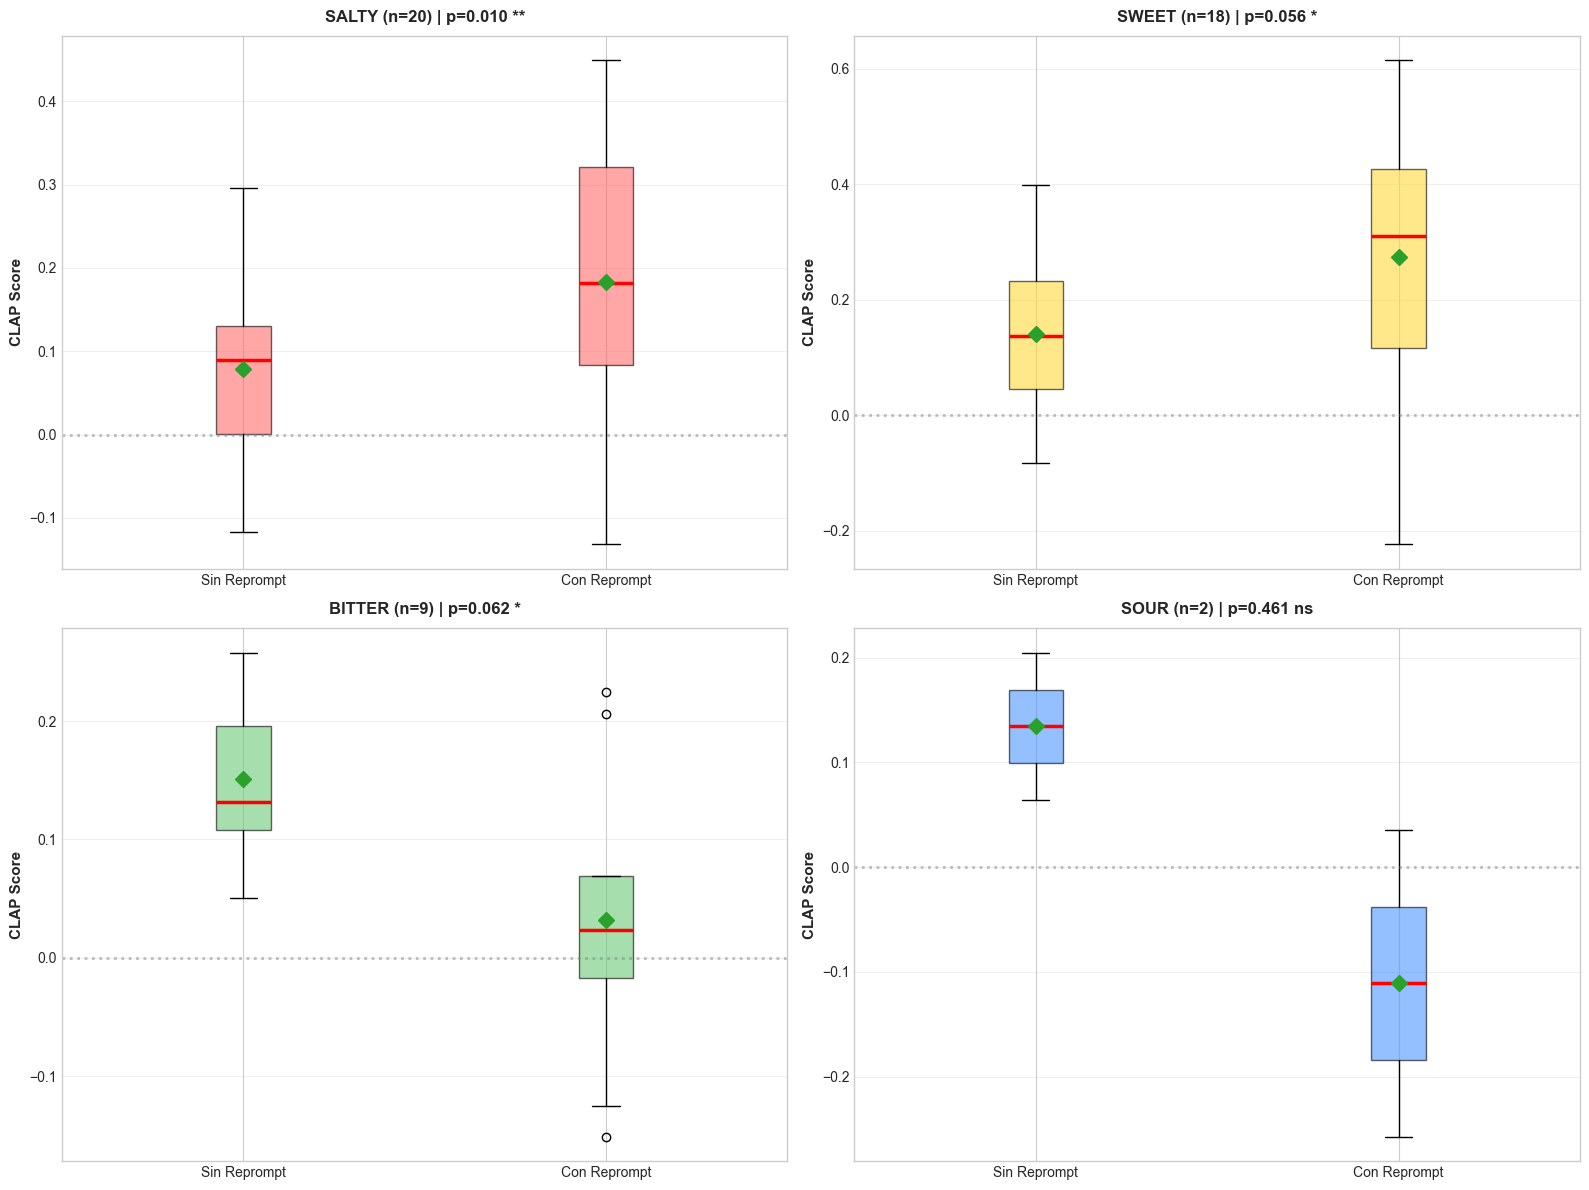

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

tastes = ['salty', 'sweet', 'bitter', 'sour']
colors = ['#FF6B6B', '#FFD93D', '#6BCB77', '#4D96FF']

for idx, (taste, color) in enumerate(zip(tastes, colors)):
    ax = axes[idx // 2, idx % 2]
    subset = comparison_df[comparison_df['taste'] == taste]

    data_to_plot = [subset['clap_score_sin_reprompt'],
                    subset['clap_score_con_reprompt']]

    bp = ax.boxplot(data_to_plot, labels=['Sin Reprompt', 'Con Reprompt'],
                    patch_artist=True, showmeans=True,
                    boxprops=dict(facecolor=color, alpha=0.6),
                    medianprops=dict(color='red', linewidth=2.5),
                    meanprops=dict(color='darkgreen', linewidth=2.5, 
                                  linestyle='--', marker='D', markersize=8))

    ax.axhline(y=0, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    ax.set_ylabel('CLAP Score', fontsize=11, fontweight='bold')

    _, p_val = stats.ttest_rel(subset['clap_score_sin_reprompt'],
                                subset['clap_score_con_reprompt'])
    sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else 'ns'

    ax.set_title(f'{taste.upper()} (n={len(subset)}) | p={p_val:.3f} {sig}',
                fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Proporción de Mejoras vs Empeoramientos

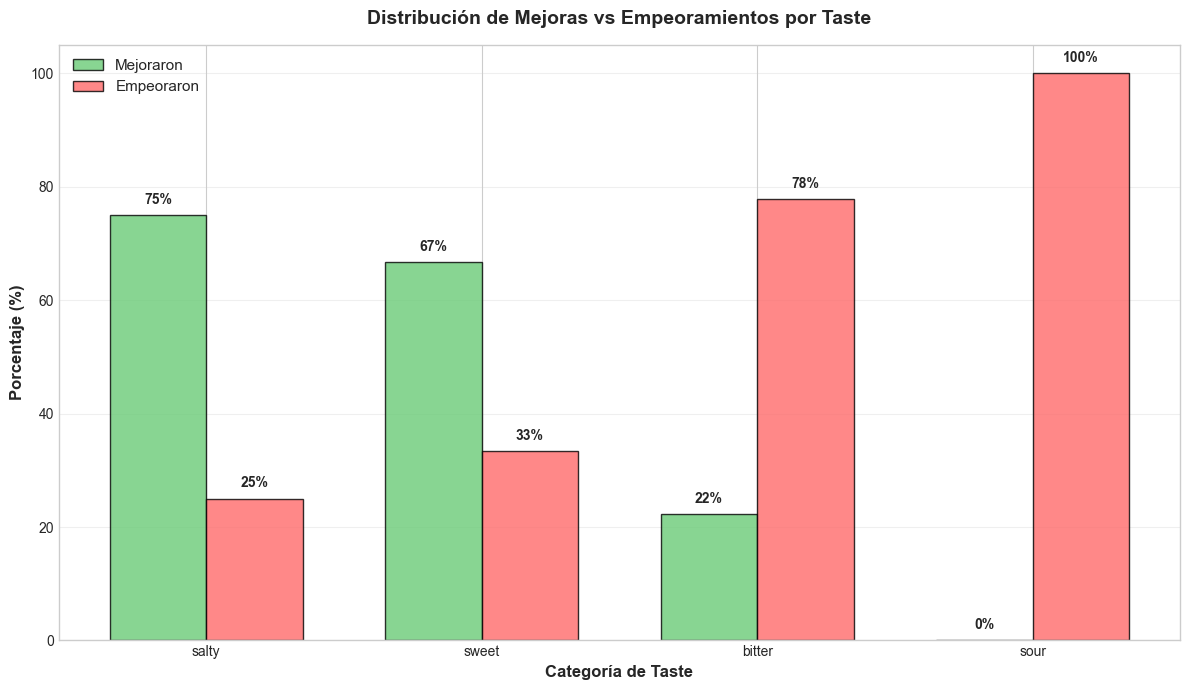

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(summary_taste_df))
width = 0.35

mejoraron = summary_taste_df['Mejoraron']
empeoraron = 100 - mejoraron

bars1 = ax.bar(x - width/2, mejoraron, width, label='Mejoraron', 
               color='#6BCB77', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, empeoraron, width, label='Empeoraron',
               color='#FF6B6B', alpha=0.8, edgecolor='black')

ax.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Categoría de Taste', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Mejoras vs Empeoramientos por Taste', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(summary_taste_df['Taste'])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')


for i, (mej, emp) in enumerate(zip(mejoraron, empeoraron)):
    ax.text(i - width/2, mej + 2, f'{mej:.0f}%', ha='center', fontsize=10, fontweight='bold')
    ax.text(i + width/2, emp + 2, f'{emp:.0f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Correlación de Kendall por Taste

Evaluamos la correlación entre scores de prompt y reprompt por categoría:

In [7]:
kendall_results = []
for taste in ['salty', 'sweet', 'bitter']:
    subset = comparison_df[comparison_df['taste'] == taste]
    tau, p_val = stats.kendalltau(subset['clap_score_sin_reprompt'],
                                    subset['clap_score_con_reprompt'])
    kendall_results.append({
        'Taste': taste,
        'N': len(subset),
        'Kendall_τ': tau,
        'p_value': p_val,
        'Interpretación': 'Fuerte' if abs(tau) > 0.6 else 'Moderada' if abs(tau) > 0.3 else 'Débil'
    })

kendall_df = pd.DataFrame(kendall_results).round(4)
kendall_df

,Taste,N,Kendall_τ,p_value,Interpretación
0,salty,20,0.1684,0.3189,Débil
1,sweet,18,-0.2026,0.2599,Débil
2,bitter,9,-0.4444,0.1194,Moderada


**Interpretación**: Correlaciones de Kendall más bajas indican mayor independencia entre prompt y reprompt para esa categoría.

## 5. Casos Extremos por Categoría

### Top Mejoras y Empeoramientos por Taste

In [8]:
for taste in ['salty', 'sweet', 'bitter', 'sour']:
    subset = comparison_df[comparison_df['taste'] == taste].copy()

    print(f"TASTE: {taste.upper()} (n={len(subset)})")

    if len(subset) >= 3:
        print(f"Top 3 Mejoras: \n")
        top_mejoras = subset.nlargest(3, 'diferencia_reprompt')[
            ['id_prompt', 'food', 'clap_score_sin_reprompt', 
             'clap_score_con_reprompt', 'diferencia_reprompt']
        ].round(4)
        display(top_mejoras)

        print(f" Top 3 Empeoramientos: \n")
        top_empeoramientos = subset.nsmallest(3, 'diferencia_reprompt')[
            ['id_prompt', 'food', 'clap_score_sin_reprompt', 
             'clap_score_con_reprompt', 'diferencia_reprompt']
        ].round(4)
        display(top_empeoramientos)
    else:
        print(f"Todos los casos: \n")
        display(subset[['id_prompt', 'food', 'clap_score_sin_reprompt', 
                        'clap_score_con_reprompt', 'diferencia_reprompt']].round(4))

TASTE: SALTY (n=20)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
4,5,chili cheese hot dog,-0.0056,0.3921,0.3977
24,25,chicken curry,-0.0641,0.2670,0.3312
33,34,tuna sandwich,0.1272,0.4492,0.3220


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
2,3,fish tacos,0.0935,-0.1317,-0.2252
48,49,spicy chicken wings,0.1831,0.0563,-0.1268
20,21,margherita pizza,0.1265,0.0196,-0.1069


TASTE: SWEET (n=18)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
13,14,honeycrisp apple,-0.0253,0.5263,0.5516
9,10,chocolate croissant,0.0745,0.6152,0.5408
21,22,chamomile tea,-0.0819,0.4310,0.5129


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
8,9,vanilla protein shake,0.1570,-0.2236,-0.3806
16,17,iced tea,0.2803,0.0756,-0.2047
36,37,jasmine tea,0.3984,0.2015,-0.1969


TASTE: BITTER (n=9)
Top 3 Mejoras: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
1,2,cappuccino,0.0887,0.2247,0.1360
14,15,latte,0.1082,0.2059,0.0977
34,35,latte,0.1316,0.0472,-0.0844


 Top 3 Empeoramientos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
47,48,turmeric latte,0.2578,-0.1514,-0.4092
17,18,flat white,0.2146,-0.0173,-0.2319
43,44,matcha latte,0.1958,0.0122,-0.1836


TASTE: SOUR (n=2)
Todos los casos: 



,id_prompt,food,clap_score_sin_reprompt,clap_score_con_reprompt,diferencia_reprompt
5,6,orange juice,0.0639,0.0357,-0.0282
10,11,lemonade,0.2049,-0.2576,-0.4625


## 7. Conclusiones

### Hallazgos Clave por Categoría de Taste

**1. SALTY (n=20): Beneficio Significativo del Reprompt**
- **Única categoría con significancia estadística** (p = 0.010 < 0.05)
- Mejora promedio: +134% en CLAP score
- 75% de los prompts mejoraron con reprompt
- Correlación Kendall moderada indica cierta independencia

**2. SWEET (n=18): Tendencia Positiva Marginal**
- Tendencia a mejora (p = 0.056, cercano al umbral)
- 67% de los prompts mejoraron
- Resultados más variables que salty

**3. BITTER (n=9): Efecto Negativo del Reprompt**
- Tendencia al empeoramiento (p = 0.062)

**4. SOUR (n=2): Muestra Insuficiente**
- Se requiere más datos para análisis confiable

---

### Comparación con Análisis Global

**Análisis Global Previo** (todas las categorías juntas):
- p = 0.08 (no significativo)
- Mejora promedio: ~50%
- Correlación Kendall general: 0.430

**Análisis Desagregado por Taste**:
- Revela patrones distintos según categoría
- Salty muestra significancia clara (p = 0.010)
- Bitter muestra efecto opuesto

El análisis agregado oculta diferencias importantes

---

### Implicaciones Prácticas de Reprompt

**1. Estrategia Diferenciada por Taste**
- No existe una solución única para todos los sabores
- La efectividad del reprompt depende del contexto semántico
- Necesario considerar características del food item

**2. Hipótesis Explicativas**
- **Salty**: Descriptores más concretos y consistentes → mejor reprompt
- **Bitter**: Descriptores más abstractos/complejos → reprompt menos efectivo
- **Sweet**: Intermedio, mayor variabilidad


### Limitaciones

- Distribución desbalanceada: salty (20) y sweet (18) vs bitter (9) y sour (2)
- Sour tiene muestra insuficiente para análisis estadístico robusto
- CLAP score como única métrica de evaluación


### Pasos por Explorar

1. **Ampliar muestra** especialmente para bitter y sour
2. **Análisis cualitativo** de prompts para identificar patrones lingüísticos
3. **Explorar otras dimensiones** sensoriales (texture, aroma, etc.)
